In this notebook we use the bounding boxes given with the [Imagenet data set](https://www.kaggle.com/c/imagenet-object-localization-challenge) to generate a new sub-set. From the original data set `Imagenet_full` by only keeping the smallest square comprising the bounding boxe we generate `Imagenet_bbox` sub-set




In [1]:
import retinoto_py as fovea
args = fovea.Params(batch_size=1, shuffle=False)
args


Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, num_epochs=10, n_train_stop=0, seed=1998, batch_size=1, num_workers=4, model_name='resnet18', do_scratch=False, lr=0.02, delta1=0.1, delta2=0.001, weight_decay=0.001, shuffle=False, verbose=True)

## reading localisation metadata

First for the 'train' dataset:

In [2]:
folder = 'train'
annotation_file = args.DATAROOT / f'LOC_{folder}_solution.csv'

import pandas as pd
with open(annotation_file, 'r') as csv_file:
    df_data = pd.read_csv(csv_file)
df_data.head()

ImageId            PredictionString
0  n02017213_7894   n02017213 115 49 448 294 
1  n02017213_7261    n02017213 91 42 330 432 
2  n02017213_5636  n02017213 230 104 414 224 
3  n02017213_6132    n02017213 46 82 464 387 
4  n02017213_7659   n02017213 103 66 331 335

In [3]:
def get_boxes(df, value):
    idx = list(df['ImageId'][df['ImageId'] == value].index)
    bboxes = []
    if idx:
        for i in range(len(df["PredictionString"][idx[0]].split(' '))//5):
            pos =(5*i)
            bboxes.append({'xmin' : int(df["PredictionString"][idx[0]].split(' ')[1 + pos]),
                           'ymin' : int(df["PredictionString"][idx[0]].split(' ')[2 + pos]),
                           'xmax' : int(df["PredictionString"][idx[0]].split(' ')[3 + (5 *i)]),
                           'ymax' : int(df["PredictionString"][idx[0]].split(' ')[4 + (5 *i)])
                                        })
    return bboxes

In [4]:
get_boxes(df_data, 'n02099849_2300')

[{'xmin': 151, 'ymin': 146, 'xmax': 332, 'ymax': 333},
 {'xmin': 7, 'ymin': 232, 'xmax': 331, 'ymax': 467}]

In [5]:
get_boxes(df_data, 'n01440764_32420')

[]

Now for the 'val' dataset:

In [6]:
folder = 'val'
annotation_file = args.DATAROOT / f'LOC_{folder}_solution.csv'

with open(annotation_file, 'r') as csv_file:
    df_data = pd.read_csv(csv_file)
df_data.head()

ImageId                                   PredictionString  \
0  ILSVRC2012_val_00048981                            n03995372 85 1 499 272    
1  ILSVRC2012_val_00037956                           n03481172 131 0 499 254    
2  ILSVRC2012_val_00026161                            n02108000 38 0 464 280    
3  ILSVRC2012_val_00026171                            n03109150 0 14 216 299    
4  ILSVRC2012_val_00008726  n02119789 255 142 454 329 n02119789 44 21 322 ...   

  origin_size  
0  (500, 360)  
1  (500, 333)  
2  (500, 334)  
3  (225, 300)  
4  (500, 357)

In [7]:
get_boxes(df_data, 'ILSVRC2012_val_00026171')

[{'xmin': 0, 'ymin': 14, 'xmax': 216, 'ymax': 299}]

In [8]:
from pathlib import Path

# Répertoire des images de validation (adapter si nécessaire)
val_dir = args.DATAROOT / 'Imagenet_full' / 'val'
N_show = 12
# Choisir quelques images (ici les 8 premières ImageId présentes dans df_data)
image_ids = df_data['ImageId'].unique()[:N_show].tolist()
image_ids

['ILSVRC2012_val_00048981',
 'ILSVRC2012_val_00037956',
 'ILSVRC2012_val_00026161',
 'ILSVRC2012_val_00026171',
 'ILSVRC2012_val_00008726',
 'ILSVRC2012_val_00023881',
 'ILSVRC2012_val_00011205',
 'ILSVRC2012_val_00048237',
 'ILSVRC2012_val_00020622',
 'ILSVRC2012_val_00045582',
 'ILSVRC2012_val_00023499',
 'ILSVRC2012_val_00039943']

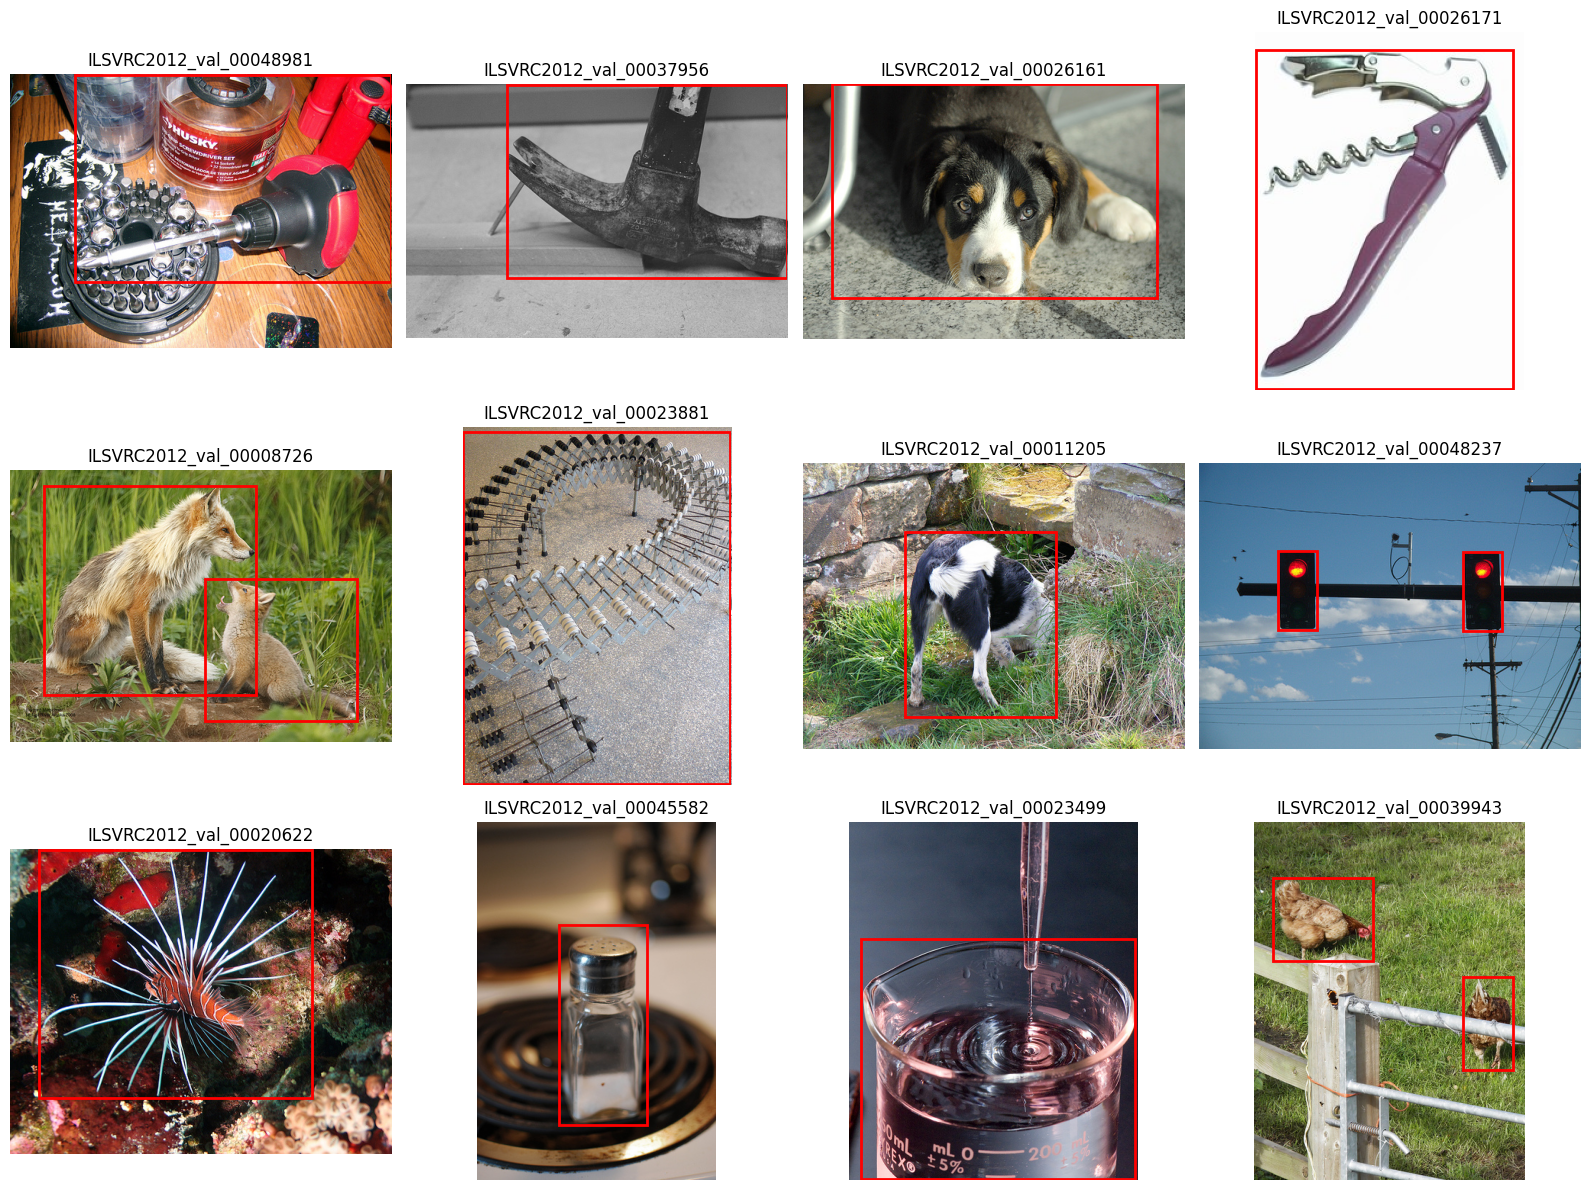

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

n = len(image_ids)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for ax_idx, imgid in enumerate(image_ids):
    ax = axes[ax_idx]
    # trouver le fichier d'image correspondant (quelque soit l'extension)
    files = list(val_dir.rglob(f'{imgid}.*'))
    if not files:
        ax.set_title(f'{imgid} not found')
        ax.axis('off')
        continue
    img_path = files[0]
    img = Image.open(img_path).convert('RGB')
    ax.imshow(img)

    # récupérer les boîtes depuis df_data via la fonction get_boxes définie plus haut
    boxes = get_boxes(df_data, imgid)
    for b in boxes:
        xmin, ymin, xmax, ymax = b['xmin'], b['ymin'], b['xmax'], b['ymax']
        w = xmax - xmin
        h = ymax - ymin
        rect = Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(imgid)
    ax.axis('off')

# masquer les axes restants si nécessaire
for i in range(len(image_ids), rows*cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## cropping and padding images


In [10]:

def bbox_to_square(xmin, ymin, xmax, ymax, margin: int = 0):
    """Retourne (cx, cy, size) du plus petit carré contenant la bbox + marge (en pixels)."""
    w = xmax - xmin
    h = ymax - ymin
    size = int(round(max(w, h))) + int(margin)
    cx = (xmin + xmax) / 2.0
    cy = (ymin + ymax) / 2.0
    return cx, cy, size

import torch
import torchvision.transforms.functional as TF

def crop_square_around_bbox(img, bbox, output_size=None, margin:int=0, fill=0):
    """
    Crop (ou pad) un carré autour de bbox.
    - img: PIL.Image ou torch.Tensor (C,H,W)
    - bbox: (xmin, ymin, xmax, ymax) en pixels (image coordinates)
    - output_size: None -> taille = taille du carré englobant ; sinon int ou (w,h)
    - margin: pixels à ajouter au carré avant crop
    - fill: valeur de remplissage pour le padding (int ou tuple)
    Retourne le patch (PIL.Image ou torch.Tensor selon l'input).
    """
    xmin, ymin, xmax, ymax = bbox
    cx, cy, size = bbox_to_square(xmin, ymin, xmax, ymax, margin=margin)

    if output_size is None:
        ow = oh = size
    elif isinstance(output_size, int):
        ow = oh = output_size
    else:
        ow, oh = output_size

    left = int(round(cx - ow / 2))
    top = int(round(cy - oh / 2))
    right = left + ow
    bottom = top + oh

    # PIL handling
    if isinstance(img, Image.Image):
        pad_left = max(0, -left)
        pad_top = max(0, -top)
        pad_right = max(0, right - img.width)
        pad_bottom = max(0, bottom - img.height)
        if any((pad_left, pad_top, pad_right, pad_bottom)):
            img = TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)
            left += pad_left
            top += pad_top
        return TF.crop(img, top, left, oh, ow)

    # Tensor handling (C,H,W)
    if isinstance(img, torch.Tensor):
        _, H, W = img.shape
        pad_left = max(0, -left)
        pad_top = max(0, -top)
        pad_right = max(0, right - W)
        pad_bottom = max(0, bottom - H)
        if any((pad_left, pad_top, pad_right, pad_bottom)):
            # TF.pad accepts tensors; padding tuple is (left, top, right, bottom)
            img = TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)
            left += pad_left
            top += pad_top
        return img[:, top:top + oh, left:left + ow]

    # fallback: convert to PIL and ré-appeler
    img_pil = TF.to_pil_image(img)
    return crop_square_around_bbox(img_pil, bbox, output_size=(ow,oh), margin=0, fill=fill)


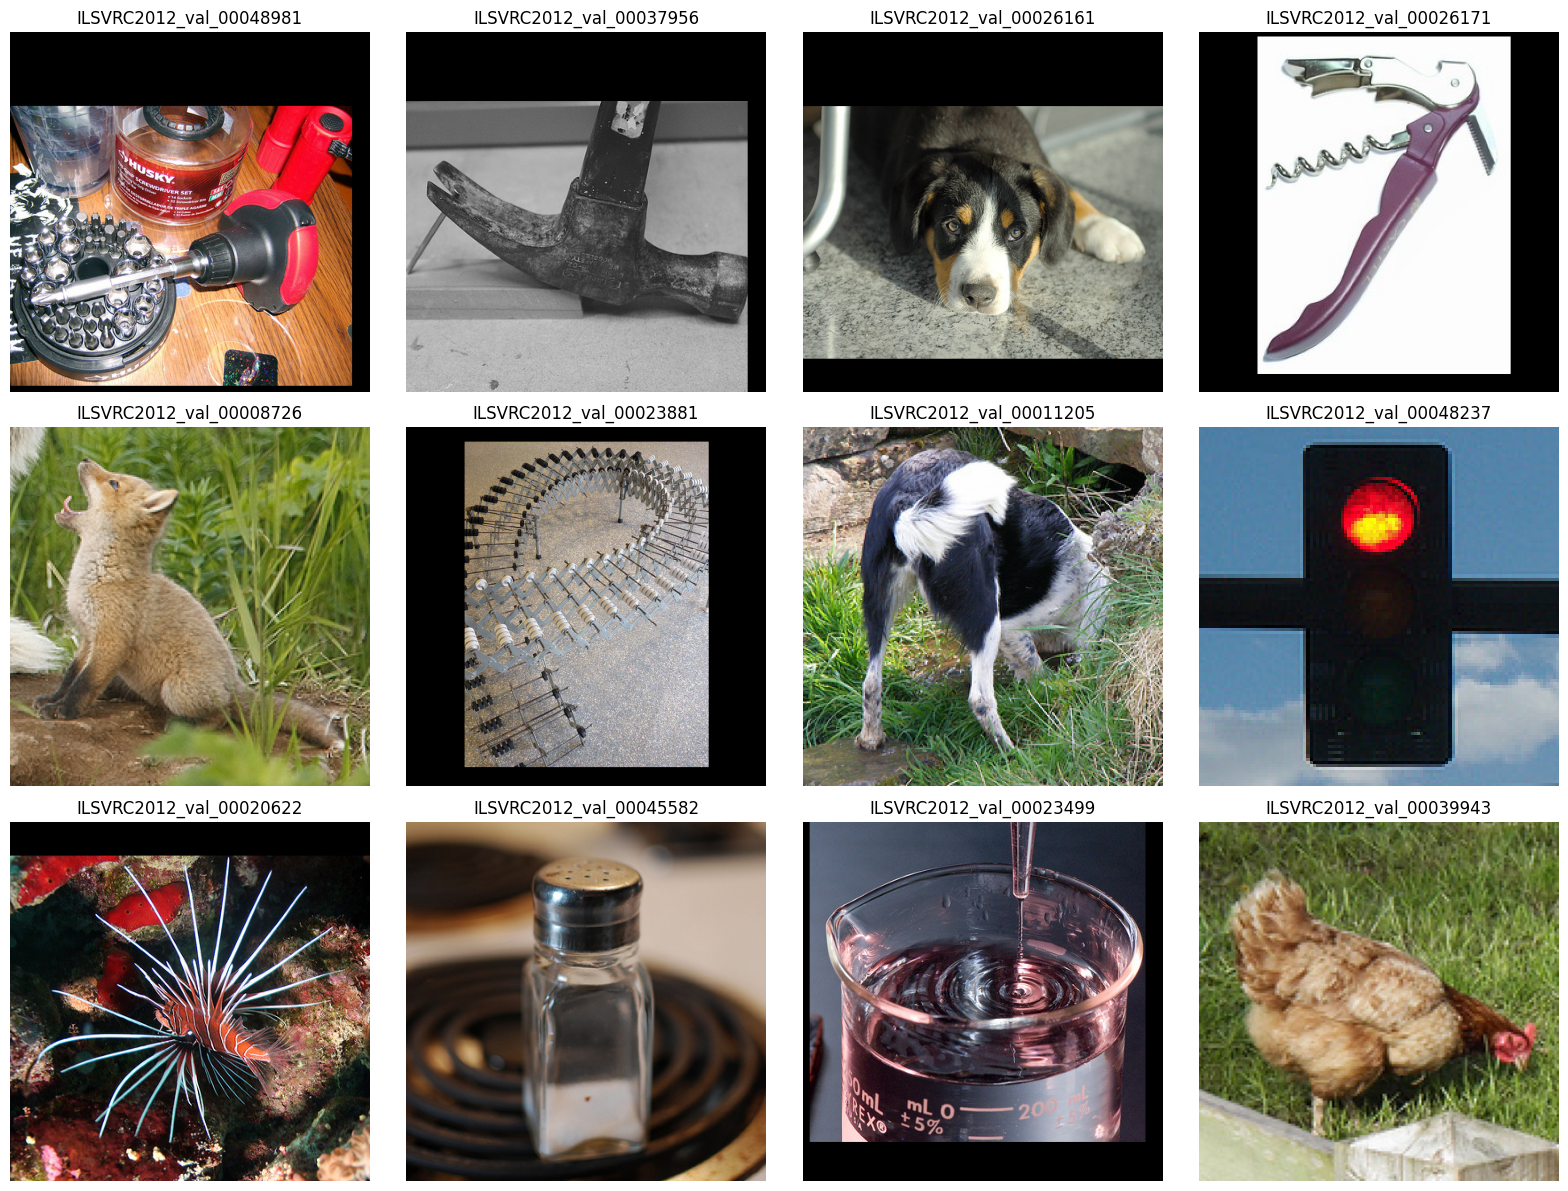

In [11]:
import numpy as np
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

rel_margin = .1 # margin computed relative to the diagonal length of the bnounding box

for ax_idx, imgid in enumerate(image_ids):
    ax = axes[ax_idx]
    # trouver le fichier d'image correspondant (quelque soit l'extension)
    files = list(val_dir.rglob(f'{imgid}.*'))
    if not files:
        ax.set_title(f'{imgid} not found')
        ax.axis('off')
        continue
    img_path = files[0]
    img = Image.open(img_path).convert('RGB')
    boxes = get_boxes(df_data, imgid)
    b = boxes[0]
    xmin, ymin, xmax, ymax = b['xmin'], b['ymin'], b['xmax'], b['ymax']
    margin = int( np.sqrt(((xmax-xmin)**2 + (ymax-ymin)**2)) * rel_margin )
    img_crop = crop_square_around_bbox(img, [xmin, ymin, xmax, ymax], margin=margin)
    ax.imshow(img_crop)

    ax.set_title(imgid)
    ax.axis('off')

# masquer les axes restants si nécessaire
for i in range(len(image_ids), rows*cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Building the new dataset


In [12]:
def clean_list(list_dir, EXCLUDED_FILES={'.DS_Store', '.ipynb_checkpoints'}):
    return [ p for p in list_dir if p.is_file() and p.name not in EXCLUDED_FILES  ]
    
FULL_DATA_DIR = args.DATAROOT / 'Imagenet_full'
src_root = FULL_DATA_DIR / 'val'
for img_path in clean_list(list(src_root.rglob('*.*'))):
    print(f'File {img_path} decomposes in a class_id = {img_path.parent.name} and a imgid = {img_path.stem}')
    break

File /Users/laurentperrinet/data/Imagenet_full/val/n04542943/ILSVRC2012_val_00049359.JPEG decomposes in a class_id = n04542943 and a imgid = ILSVRC2012_val_00049359


In [ ]:
from retinoto_py import get_loader, imshow
from tqdm.auto import tqdm


FULL_DATA_DIR = args.DATAROOT / 'Imagenet_full'
BBOX_DATA_DIR = args.DATAROOT / 'Imagenet_bbox'
BBOX_DATA_DIR.mkdir(exist_ok=True)
IMG_EXTS = {'.jpg', '.jpeg', '.JPEG', '.png', '.bmp'}

# parameters for the new dataset
format = 'png' # lossless encoding
rel_margin = .1 # margin computed relative to the diagonal length of the bnounding box

for folder in ['val', 'train']:
    print(f'\nFolder "{folder}"')
    annotation_file = args.DATAROOT / f'LOC_{folder}_solution.csv'
    with open(annotation_file, 'r') as csv_file:
        df_data = pd.read_csv(csv_file)

    src_root = FULL_DATA_DIR / folder
    tgt_root = BBOX_DATA_DIR / folder
    tgt_root.mkdir(parents=True, exist_ok=True)

    count_in = 0
    count_out = 0

    # parcours récursif avec pathlib
    for img_path in tqdm(clean_list(list(src_root.rglob('*.*')))):
        if not img_path.is_file() or img_path.suffix not in IMG_EXTS:
            print(f'File {img_path} is detected as an invalid image.')
            continue

        count_in += 1
        imgid = img_path.stem
        # Get the list of bounding boxes for a specific image. If that list is empty (meaning no boxes were found for this image), then skip to the next image and don't run any code that comes after this line.
        boxes = get_boxes(df_data, imgid)
        if not boxes:
            continue

        class_id = img_path.parent.name
        target_folder = tgt_root / class_id
        target_folder.mkdir(parents=True, exist_ok=True)

        original_image = None
        for i_obj, b in enumerate(boxes):
            no = '' if i_obj == 0 else f'_{i_obj}'
            out_path = target_folder / f'{imgid}{no}.{format}'
            if out_path.is_file():
                # the file already exists let's skip it
                count_out += 1
                continue

            if original_image is None:
                try:
                    original_image = Image.open(img_path).convert('RGB')
                    print(f'opening {img_path} ')
                except Exception as e:
                    print(f'  could not open {img_path}: {e}')
                    break

            xmin, ymin, xmax, ymax = b['xmin'], b['ymin'], b['xmax'], b['ymax']
            margin = int( np.sqrt(((xmax-xmin)**2 + (ymax-ymin)**2)) * rel_margin )
            crop_image = crop_square_around_bbox(original_image, (xmin, ymin, xmax, ymax), margin=margin)
            crop_image.save(out_path, format=format)
            count_out += 1

    print(f' - in: {count_in} / out: {count_out}')


Folder "val"


  0%|          | 0/50000 [00:00<?, ?it/s]

 - in: 50000 / out: 80477

Folder "train"


  0%|          | 0/1281167 [00:00<?, ?it/s]

## Showcasing the new dataset


In [ ]:
val_dir = args.DATAROOT / 'Imagenet_bbox' / 'val'

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for ax_idx, imgid in enumerate(image_ids):
    ax = axes[ax_idx]
    # trouver le fichier d'image correspondant (quelque soit l'extension)
    files = list(val_dir.rglob(f'{imgid}.*'))
    if not files:
        ax.set_title(f'{imgid} not found')
        ax.axis('off')
        continue
    img_path = files[0]
    img = Image.open(img_path).convert('RGB')
    boxes = get_boxes(df_data, imgid)
    b = boxes[0]
    xmin, ymin, xmax, ymax = b['xmin'], b['ymin'], b['xmax'], b['ymax']
    margin = int( np.sqrt(((xmax-xmin)**2 + (ymax-ymin)**2)) *.1 )
    img_crop = crop_square_around_bbox(img, [xmin, ymin, xmax, ymax], margin=margin)
    ax.imshow(img_crop)

    ax.set_title(imgid)
    ax.axis('off')

# masquer les axes restants si nécessaire
for i in range(len(image_ids), rows*cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Voilà !